In [1]:
import xarray as xr
import intake, intake_xarray
import dask
import ac3airborne 
from dask.distributed import Client, LocalCluster

# Set up a cluster and client

cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38181 instead
  warnings.warn(


In [2]:
cat = intake.open_catalog('/projekt_agmwend/home_rad/Joshua/LIM_intake/catalog.yaml')
meta = ac3airborne.get_flight_segments()


In [3]:
dates = []

for airplane in list(cat['HALO-AC3']):
    if airplane == 'HALO':
        dataset_name = 'KT19'
    else:
        dataset_name = 'BBR_KT19'
    print(list(cat['HALO-AC3'][airplane][dataset_name]))

['HALO-AC3_20220320_P5_RF01', 'HALO-AC3_20220322_P5_RF02', 'HALO-AC3_20220322_P5_RF03', 'HALO-AC3_20220325_P5_RF04', 'HALO-AC3_20220328_P5_RF05', 'HALO-AC3_20220329_P5_RF06', 'HALO-AC3_20220329_P5_RF07', 'HALO-AC3_20220330_P5_RF08', 'HALO-AC3_20220401_P5_RF09', 'HALO-AC3_20220404_P5_RF10', 'HALO-AC3_20220405_P5_RF11', 'HALO-AC3_20220407_P5_RF12', 'HALO-AC3_20220410_P5_RF13']
['HALO-AC3_20220320_P6_RF01', 'HALO-AC3_20220322_P6_RF02', 'HALO-AC3_20220324_P6_RF03', 'HALO-AC3_20220326_P6_RF04', 'HALO-AC3_20220328_P6_RF05', 'HALO-AC3_20220329_P6_RF06', 'HALO-AC3_20220330_P6_RF07', 'HALO-AC3_20220401_P6_RF08', 'HALO-AC3_20220404_P6_RF09', 'HALO-AC3_20220405_P6_RF10', 'HALO-AC3_20220408_P6_RF11', 'HALO-AC3_20220409_P6_RF12', 'HALO-AC3_20220410_P6_RF13']
['HALO-AC3_20220312_HALO_RF02', 'HALO-AC3_20220313_HALO_RF03', 'HALO-AC3_20220314_HALO_RF04', 'HALO-AC3_20220315_HALO_RF05', 'HALO-AC3_20220316_HALO_RF06', 'HALO-AC3_20220320_HALO_RF07', 'HALO-AC3_20220321_HALO_RF08', 'HALO-AC3_20220328_HALO_RF

In [4]:
cat['HALO-AC3']['P6']['BBR_KT19']['HALO-AC3_20220401_P6_RF08'].to_dask()

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset>
Dimensions:                   (Time: 372939)
Dimensions without coordinates: Time
Data variables: (12/19)
    time                      (Time) datetime64[ns] ...
    Lon                       (Time) float32 ...
    Lat                       (Time) float32 ...
    Alt                       (Time) float32 ...
    SZA                       (Time) float32 ...
    SAA                       (Time) float32 ...
    ...                        ...
    Cloud_Flag                (Time) int8 ...
    Attitude_Flag             (Time) int8 ...
    Ambient_Temperature_Flag  (Time) int8 ...
    Airc_Stabilizer_flag      (Time) int8 ...
    Pyrano_Icing_Flag         (Time) int8 ...
    Pyrgeo_Icing_Flag         (Time) int8 ...
Attributes:
    title:                Broadband irradiance measurements onboard Polar 5 a...
    project:              (AC)3
    mission:              HALO-(AC)3
    ongoing_subset:       RF08
    research_flight_day:  2022-04-01
    platform:             P6
    instrument:           Kipp&Zonen CMP22 pyranometer and CGR4 pyrgeometer a...
    version:              1
    date_created:         2023-10-19
    history:              created 2023-10-19
    contact:              Sebastian Becker (sebastian.becker@uni-leipzig.de)
    institution:          Leipzig Institute for Meteorology, Leipzig, Germany

In [5]:
ds_P5 = []
ds_P6 = []
ds_HALO = []


for flight_id, flight in meta['HALO-AC3']['HALO'].items():        
    campaign, airplane, rf = flight_id.split('_')
    fd = flight['date'].strftime('%Y%m%d')
    if len(flight['co-location']) > 0: 

        new_flight_id = f'{campaign}_{fd}_{airplane}_{rf}'
        KT_19 = cat['HALO-AC3']['HALO']['KT19'][new_flight_id].to_dask()
        BAHAMAS = cat['HALO-AC3']['HALO']['BAHAMAS'][new_flight_id].to_dask()
        BAHAMAS = BAHAMAS.assign_coords({'time': BAHAMAS.TIME})

        xrHALO = xr.Dataset(
            data_vars=dict(
                lat=(['time'],  BAHAMAS['IRS_LAT'].values),
                lon=(['time'],  BAHAMAS['IRS_LON'].values),
                alt=(['time'],  BAHAMAS['IRS_ALT'].values),
                roll=(['time'], BAHAMAS['IRS_PHI'].values),
                pitch=(['time'],BAHAMAS['IRS_THE'].values),
                hdg=(['time'],  BAHAMAS['IRS_HDG'].values),
                gs=(['time'],   BAHAMAS['IRS_GS'].values),
            
            ),
            coords=dict(
            
                time=BAHAMAS['TIME'].values,
            ),
        )   

        KT_19_georef = xr.Dataset(
            data_vars=dict(
                TB_KT19 = ('time', KT_19['temp_bright'].values),
                TS_KT19 = ('time', KT_19['temp_KT19'].values),
                lat = ('time', xrHALO.lat.interp_like(KT_19.time).values),
                lon = ('time', xrHALO.lon.interp_like(KT_19.time).values),
            ),
            coords=dict(
                time = KT_19.time.values,

            ),
        )
        ds_HALO.append(KT_19_georef)

        for polar_flight_id in flight['co-location']:
            campaign, airplane, rf = polar_flight_id.split('_')
            fd = flight['date'].strftime('%Y%m%d')
            new_flight_id = f'{campaign}_{fd}_{airplane}_{rf}'
            if airplane == 'P5':
                ds_P5.append(cat['HALO-AC3']['P5']['BBR_KT19'][new_flight_id].to_dask())
            elif airplane == 'P6':
                ds_P6.append(cat['HALO-AC3']['P6']['BBR_KT19'][new_flight_id].to_dask())


ds_P5 = xr.concat(ds_P5, dim='Time')
ds_P5 = ds_P5.assign_coords({'time': ('Time', ds_P5.time.values)})
ds_P6 = xr.concat(ds_P6, dim='Time')
ds_P6 = ds_P6.assign_coords({'time': ('Time', ds_P6.time.values)})
ds_HALO = xr.concat(ds_HALO, dim='time')

ds_P5 = xr.Dataset(
    data_vars=dict(
        KT19 = ('time', ds_P5.KT19.values), 
        lat = ('time', ds_P5.Lat.values),
        lon = ('time', ds_P5.Lon.values),
    ),
    coords=dict(
        time = ds_P5.time.values,
    ),
)

ds_P6 = xr.Dataset(
    data_vars=dict(
        KT19 = ('time', ds_P6.KT19.values), 
        lat = ('time', ds_P6.Lat.values),
        lon = ('time', ds_P6.Lon.values),
    ),
    coords=dict(
        time = ds_P6.time.values,
    ),
)




/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `Data

In [6]:
ds_P5 = ds_P5.resample(time='1s').mean()
ds_P6 = ds_P6.resample(time='1s').mean()
ds_HALO = ds_HALO.resample(time='1s').nearest()

ds_HALO = ds_HALO.where((ds_HALO.lat > 75) & (ds_HALO.lat < 81), drop=True)


In [7]:
#find intersection of airplanes flying, only if HALO if one of the other airplanes fly

ds_P5 = ds_P5.where(ds_P5.time.isin(ds_HALO.time), drop=True)
ds_P6 = ds_P6.where(ds_P6.time.isin(ds_HALO.time), drop=True)
ds_P6

<xarray.Dataset>
Dimensions:  (time: 119632)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-20T11:33:10 ... 2022-04-10T14:07:02
Data variables:
    KT19     (time) float32 257.9 257.9 258.0 257.9 257.9 ... nan nan nan nan
    lat      (time) float32 78.42 78.42 78.42 78.42 ... 78.25 78.25 78.25 78.25
    lon      (time) float32 13.71 13.71 13.7 13.7 ... 15.43 15.43 15.43 15.43

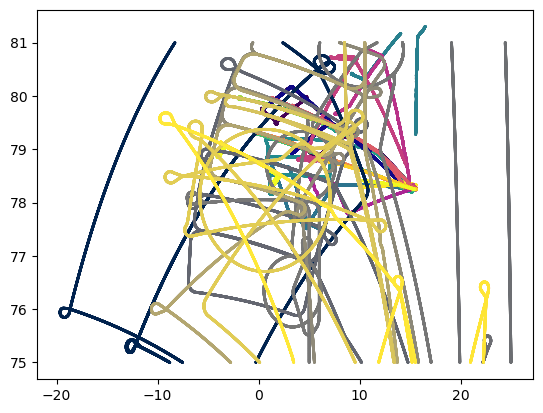

In [8]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()    

cmaps=['viridis', 'plasma', 'cividis']

for i, ds in enumerate([ds_P5, ds_P6, ds_HALO]):

    x = ds.lon.values
    y = ds.lat.values
    c = ds.time.values

    sc = ax.scatter(x, y, c=c, cmap=cmaps[i], s=1, label=ds)


In [9]:
from tqdm import tqdm
from haversine import haversine, Unit

dist_P5 = []
dist_P6 = []


for i, time in tqdm(enumerate(ds_HALO.time.values)):

    HALO_pos = (ds_HALO.lat.values[i], ds_HALO.lon.values[i])
    P5_pos = (ds_P5.sel(time=time, method='nearest').lat.item(), ds_P5.sel(time=time, method='nearest').lon.item())
    P6_pos = (ds_P6.sel(time=time, method='nearest').lat.item(), ds_P6.sel(time=time, method='nearest').lon.item())

    dist_P5.append(haversine(HALO_pos, P5_pos, unit=Unit.METERS))
    dist_P6.append(haversine(HALO_pos, P6_pos, unit=Unit.METERS))



0it [00:00, ?it/s]

128146it [05:42, 374.67it/s]


In [10]:
ds_HALO['dist_P5'] = ('time', dist_P5)  
ds_HALO['dist_P6'] = ('time', dist_P6)

In [11]:
P6_time = ds_HALO.where(ds_HALO.dist_P6 < 6000, drop=True).time[5:]
P5_time = ds_HALO.where(ds_HALO.dist_P5 < 6000, drop=True).time


In [12]:
list(cat['HALO-AC3']['HALO']['VELOX'])

ds_vel = cat['HALO-AC3']['HALO']['VELOX']['HALO-AC3_20220401_HALO_RF12'](filter=1).to_dask()

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [13]:
P6_time.sel(time='2022-04-01T10')

<xarray.DataArray 'time' (time: 81)>
array(['2022-04-01T10:20:39.000000000', '2022-04-01T10:20:40.000000000',
       '2022-04-01T10:20:41.000000000', '2022-04-01T10:20:42.000000000',
       '2022-04-01T10:20:43.000000000', '2022-04-01T10:20:44.000000000',
       '2022-04-01T10:20:45.000000000', '2022-04-01T10:20:46.000000000',
       '2022-04-01T10:20:47.000000000', '2022-04-01T10:20:48.000000000',
       '2022-04-01T10:20:49.000000000', '2022-04-01T10:20:50.000000000',
       '2022-04-01T10:20:51.000000000', '2022-04-01T10:20:52.000000000',
       '2022-04-01T10:20:53.000000000', '2022-04-01T10:20:54.000000000',
       '2022-04-01T10:20:55.000000000', '2022-04-01T10:20:56.000000000',
       '2022-04-01T10:20:57.000000000', '2022-04-01T10:20:58.000000000',
       '2022-04-01T10:20:59.000000000', '2022-04-01T10:21:00.000000000',
       '2022-04-01T10:21:01.000000000', '2022-04-01T10:21:02.000000000',
       '2022-04-01T10:21:03.000000000', '2022-04-01T10:21:04.000000000',
       '2022-04-01T10:21:05.000000000', '2022-04-01T10:21:06.000000000',
       '2022-04-01T10:21:07.000000000', '2022-04-01T10:21:08.000000000',
       '2022-04-01T10:21:09.000000000', '2022-04-01T10:21:10.000000000',
       '2022-04-01T10:21:11.000000000', '2022-04-01T10:21:12.000000000',
       '2022-04-01T10:21:13.000000000', '2022-04-01T10:21:14.000000000',
       '2022-04-01T10:21:15.000000000', '2022-04-01T10:21:16.000000000',
       '2022-04-01T10:21:17.000000000', '2022-04-01T10:21:18.000000000',
       '2022-04-01T10:21:19.000000000', '2022-04-01T10:21:20.000000000',
       '2022-04-01T10:21:21.000000000', '2022-04-01T10:21:22.000000000',
       '2022-04-01T10:21:23.000000000', '2022-04-01T10:21:24.000000000',
       '2022-04-01T10:21:25.000000000', '2022-04-01T10:21:26.000000000',
       '2022-04-01T10:21:27.000000000', '2022-04-01T10:21:28.000000000',
       '2022-04-01T10:21:29.000000000', '2022-04-01T10:21:30.000000000',
       '2022-04-01T10:21:31.000000000', '2022-04-01T10:21:32.000000000',
       '2022-04-01T10:21:33.000000000', '2022-04-01T10:21:34.000000000',
       '2022-04-01T10:21:35.000000000', '2022-04-01T10:21:36.000000000',
       '2022-04-01T10:21:37.000000000', '2022-04-01T10:21:38.000000000',
       '2022-04-01T10:21:39.000000000', '2022-04-01T10:21:40.000000000',
       '2022-04-01T10:21:41.000000000', '2022-04-01T10:21:42.000000000',
       '2022-04-01T10:21:43.000000000', '2022-04-01T10:21:44.000000000',
       '2022-04-01T10:21:45.000000000', '2022-04-01T10:21:46.000000000',
       '2022-04-01T10:21:47.000000000', '2022-04-01T10:21:48.000000000',
       '2022-04-01T10:21:49.000000000', '2022-04-01T10:21:50.000000000',
       '2022-04-01T10:21:51.000000000', '2022-04-01T10:21:52.000000000',
       '2022-04-01T10:21:53.000000000', '2022-04-01T10:21:54.000000000',
       '2022-04-01T10:21:55.000000000', '2022-04-01T10:21:56.000000000',
       '2022-04-01T10:21:57.000000000', '2022-04-01T10:21:58.000000000',
       '2022-04-01T10:21:59.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01T10:20:39 ... 2022-04-01T10:21:59

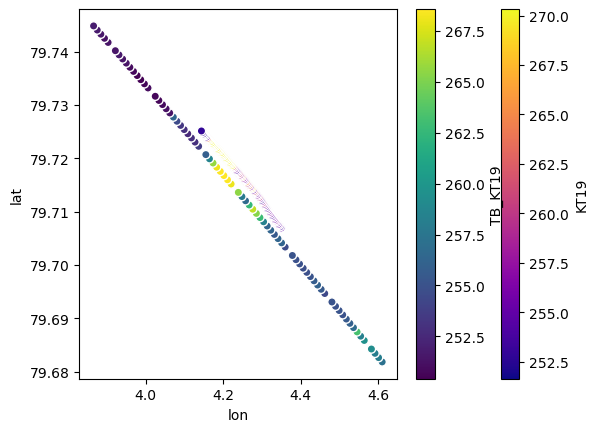

In [14]:
ds_P6.sel(time=P6_time.sel(time='2022-04-01T10')).plot.scatter(x='lon', y='lat', hue='KT19', cmap='plasma')

ds_HALO.sel(time=P6_time.sel(time='2022-04-01T10')).plot.scatter(x='lon', y='lat', hue='TB_KT19', cmap='viridis')

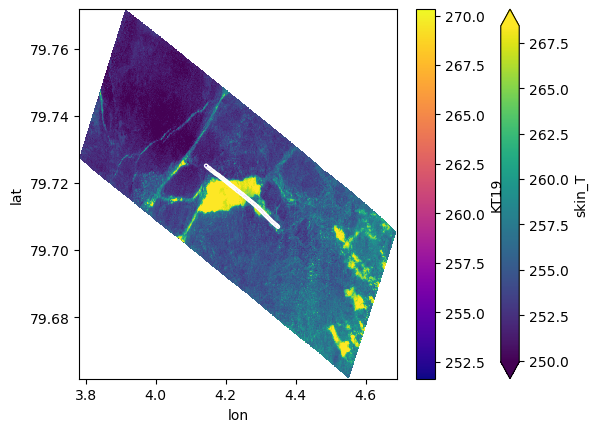

In [75]:
VELOX_georef = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/VELOX_2022-04-01:10:20:00_Polar6_underflight_1.nc')


(VELOX_georef.skin_T + 273.15).plot(cmap='viridis', robust=True)
ds_P6.sel(time=P6_time.sel(time='2022-04-01T10')).plot.scatter(x='lon', y='lat', hue='KT19', cmap='plasma', s = 5)



In [30]:
import pandas as pd
P6_info = pd.read_csv('/projekt_agmwend/data/HALO-AC3/02_Flights/HALO-AC3_20220401_P6_RF08/Meteo/Flight_20220401_P6_08_1s.asc', delim_whitespace=True, header=None, names=
                      ['UTC', 'h', 'lon', 'lat', 'p', 'gs', 'pitch', 'roll', 'rh', 'T', 'u', 'v', 'tas'], skiprows=1)

/tmp/ipykernel_1007144/595484348.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  P6_info = pd.read_csv('/projekt_agmwend/data/HALO-AC3/02_Flights/HALO-AC3_20220401_P6_RF08/Meteo/Flight_20220401_P6_08_1s.asc', delim_whitespace=True, header=None, names=


In [33]:
from datetime import datetime, timedelta    

date = '2022-04-01' 

P6_info['time'] = [pd.to_datetime(date) + timedelta(seconds=int(t)) for t in P6_info.UTC]

In [67]:
VELOX_georef.lat

<xarray.DataArray 'lat' (lat: 1000)>
array([79.663201, 79.663308, 79.663415, ..., 79.770076, 79.770183, 79.77029 ])
Coordinates:
  * lat      (lat) float64 79.66 79.66 79.66 79.66 ... 79.77 79.77 79.77 79.77

In [78]:
closest_velox = []
start = P6_time.sel(time='2022-04-01T10')[0]
end = P6_time.sel(time='2022-04-01T10')[-1]


for time in tqdm(ds_P6.sel(time=slice(start, end)).time.values):
    lat, lon = ds_P6.sel(time=time).lat.item(), ds_P6.sel(time=time).lon.item()

    lat_range = [lat-0.001, lat+0.001]
    lon_range = [lon-0.01, lon+0.01]

    velox = VELOX_georef.sel(lat=slice(*lat_range), lon=slice(*lon_range)).skin_T.mean().item()
    velox = VELOX_georef.sel(lat=lat, lon=lon, method='nearest').skin_T.mean().item()
    print(velox)
    print(lat, lon)
    closest_velox.append(velox)


closest_velox = xr.DataArray(closest_velox, dims='time', coords={'time': ds_P6.sel(time=slice(start, end)).time.values})

100%|██████████| 81/81 [00:00<00:00, 480.88it/s]

-18.56947576623144
79.70692443847656 4.349189758300781
-17.18890642849682
79.7071762084961 4.346614837646484
-18.44848571479363
79.70744323730469 4.344120502471924
-17.767813763306556
79.70759582519531 4.341553688049316
-18.35209296725408
79.7078628540039 4.338969707489014
-16.48090247175029
79.70811462402344 4.336489200592041
-15.618581630547483
79.70829772949219 4.3339948654174805
-17.502579810383537
79.70854187011719 4.331509590148926
-14.970621201456098
79.70880889892578 4.329100608825684
-16.589622672007167
79.70906066894531 4.326704025268555
-14.770005811987023
79.70931243896484 4.324209690093994
-15.993073187847529
79.7095718383789 4.321723937988281
-16.39997902611378
79.70984649658203 4.319230079650879
-14.008853195068799
79.71009063720703 4.316749572753906
-8.150972277034201
79.71035766601562 4.31433629989624
-7.466956528980967
79.71060180664062 4.311938285827637
-9.169344447037803
79.71086883544922 4.309450149536133
-10.63348116920892
79.71112823486328 4.30696439743042
-8.494

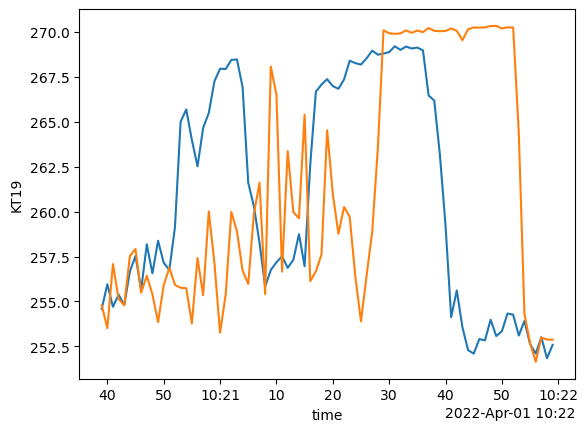

In [79]:
(closest_velox + 273.15).plot()


P6_sel = ds_P6.sel(time=slice(start, end))

P6_sel.KT19.plot()

In [38]:
P6_info_xr = xr.Dataset(
    data_vars=dict(
        lat = ('time', P6_info.lat.values),
        lon = ('time', P6_info.lon.values),
        alt = ('time', P6_info.h.values),
        pitch = ('time', P6_info.pitch.values),
        roll = ('time', P6_info.roll.values),
        rh = ('time', P6_info.rh.values),
        u = ('time', P6_info.u.values),
        v = ('time', P6_info.v.values),
        tas = ('time', P6_info.tas.values),
    ),
    coords=dict(
        time = P6_info.time.values,
    ),
)

In [53]:
ds_HALO.sel(time=P6_time.sel(time='2022-04-01T10'))

<xarray.Dataset>
Dimensions:  (time: 81)
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01T10:20:39 ... 2022-04-01T10:21:59
Data variables:
    TB_KT19  (time) float64 257.2 258.1 258.1 259.2 ... 251.2 251.5 251.7 251.9
    TS_KT19  (time) float64 284.4 284.4 284.4 284.4 ... 284.3 284.3 284.3 284.3
    lat      (time) float64 79.68 79.68 79.68 79.68 ... 79.74 79.74 79.74 79.74
    lon      (time) float64 4.61 4.6 4.591 4.582 ... 3.894 3.885 3.875 3.866
    dist_P5  (time) float64 7.685e+03 7.541e+03 ... 3.967e+03 4.104e+03
    dist_P6  (time) float64 5.885e+03 5.739e+03 ... 5.781e+03 5.926e+03

In [ ]:
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import xarray as xr

ds = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-01_v_0.1.nc', chunks={'time': 250, 'x' : 250, 'y' : 250})
#ds[['vaa', 'vza', 'yaw', 'lat', 'lon', 'alt']] =  ds_vel[['vaa', 'vza', 'yaw', 'lat', 'lon', 'alt']]
#ds_sel = ds.sel(time='2022-04-04T13:43:10', method='nearest')

ds_sel_array = ds.sel(time=slice('2022-04-01T10:20:00', '2022-04-01T10:22:00')).persist()

@widgets.interact(time=widgets.IntSlider(min=0, max=ds_sel_array.time.size-1, step=1, value=0))

def plot_map(time):
    clear_output(wait=True)

    #fig, ax = plt.gcf(), plt.gcf().get_axes()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    im2 = ds_sel_array.BT_2D.isel(time=time, band=0).plot(ax=ax[0], cmap='plasma', vmin=-30, vmax=0, add_colorbar=False)
    ax[1].set_aspect('equal')
    ax[0].set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax[1], fraction=0.05, pad=0.04)
    cbar.set_ticks([1, 2, 4])
    cbar.set_ticklabels(['Open Water', 'Thin Ice', 'Thick Ice'])
    cbar = fig.colorbar(im2, ax=ax[0], fraction=0.05, pad=0.04)
    cbar.set_label('T_skin [°C]')
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])    
    ax[1].set_title('')	
    fig.canvas.draw_idle()
    plt.show()


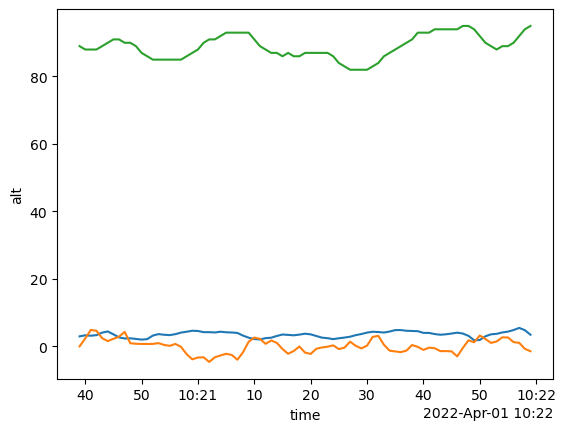

In [54]:
P6_info_xr.sel(time=slice(start, end)).pitch.plot()
P6_info_xr.sel(time=slice(start, end))['roll'].plot()
P6_info_xr.sel(time=slice(start, end)).alt.plot()
